In [0]:
import time
import numpy as np
from keras import backend
from PIL import Image
from keras.models import Model
from keras.applications.vgg19 import VGG19

from scipy.optimize import fmin_l_bfgs_b
from imageio import imsave

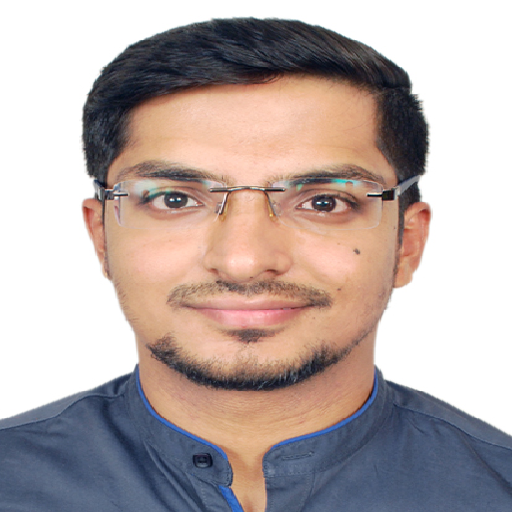

In [40]:
hieght=512
width=512

content_img=Image.open("husain_foto.jpg")
content_img=content_img.resize((width,hieght))
content_img

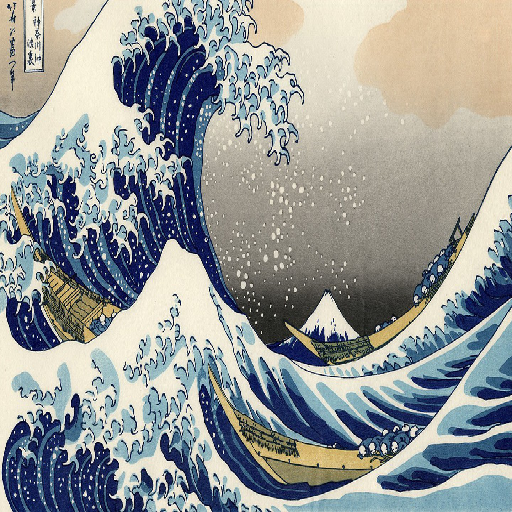

In [41]:
style_img=Image.open("wave_art.jpg")
style_img=style_img.resize((width,hieght))
style_img

In [42]:
#converting images to suitable form of array  batch_size x width x height x channels
content_array_original=np.asarray(content_img,dtype="float32")
content_array=np.expand_dims(content_array_original,axis=0)
print(content_array.shape)

style_array_original=np.asarray(style_img,dtype="float32")
style_array=np.expand_dims(style_array_original,axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
#normalize input. take mean of training set for each of 3 channels, RGB=[103.939, 116.779, 123.68]
#and reverse the order of channels from RGB to BGR

content_array[:,:,:,0] -= 103.939
content_array[:,:,:,1] -= 116.779
content_array[:,:,:,2] -= 123.68
content_array=content_array[:,:,:,::-1]  #reverse channels order


style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68
style_array=style_array[:,:,:,::-1]  #reverse channels order

In [0]:
content_img=backend.variable(content_array,name="content")
style_img=backend.variable(style_array,name="style")
combination_img=backend.placeholder(shape=(1,hieght,width,3),dtype="float32",name="combination")

In [0]:
input_tensor= backend.concatenate([content_img,style_img,combination_img],axis=0)  #concatenate for VGG19 to work

In [0]:
##Use pretrained VGG19 model layers except FC and softmax layers
model=VGG19(include_top=False,weights="imagenet",input_tensor=input_tensor)

In [47]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Now we will introduce 3 type of losses as this is  sort of optimization problem.
1. Content loss  --> Loss(Combination Img,Content Img)
2. style loss  --> Loss(Combination Img, Style Img)
3. total variational loss --> (a regularisation term) that encourages spatial smoothness. Inspired from [paper](https://arxiv.org/abs/1412.0035)

In [0]:
#weights of each loss

content_weight = 0.25
style_weight = 2.0
total_variation_weight = 1.0

#initialize total loss to 0 and add it in every stage
loss = backend.variable(0.0)

For content loss let's take low level layers at it preserves structural details. Hence we take **block3_conv4**. Can be experimental.

In [0]:
def content_loss(content,combination):   #sum of squared error (Eucliedean distance)
  return backend.sum(backend.square(content-combination))

In [50]:
layer_features=model.get_layer("block3_conv4")
print(layer_features.output.shape)  #batch,row,col,filters

(3, 128, 128, 256)


In [0]:
#batch=0 corresponds to content img (as passed in input_tensor)
content_img_features=layer_features.output[0,:,:,:]
#batch=2 corresponds to combination img (as passed in input_tensor)
combination_img_features=layer_features.output[2,:,:,:]

loss = loss + content_weight * content_loss(content_img_features,combination_img_features)

For style loss, we will introduce concept of Gram Matrix. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together.

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

In [0]:
def gram_matrix(x):
  features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
  gram_mat=backend.dot(features,backend.transpose(features))
  return gram_mat

In [0]:
def style_loss(style,combination):
  S=gram_matrix(style)
  C=gram_matrix(combination)

  chn=3
  size=hieght*width
  
  s_loss=backend.sum(backend.square(S-C)) / (4 * (chn**2) * (size**2))
  return s_loss

In [0]:
feature_layers=["block1_conv2","block2_conv2"] #,"block3_conv4","block4_conv4","block5_conv4"

In [0]:
for layer_name in feature_layers:
  layer_features=model.get_layer(layer_name)
  style_features=layer_features.output[1,:,:,:]
  combination_features=layer_features.output[2,:,:,:]
  s_loss=style_loss(style_features,combination_features)
  loss = loss + (style_weight*len(feature_layers))*s_loss

Now we add total variation loss which acts as regularisation term to ensure spatial smoothness. We refer to formula given in paper mentioned before.

In [0]:
def total_variational_loss(x):
  a = backend.square(x[:,:hieght-1,1:,:] - x[:,:hieght-1,:width-1,:])  #X_i,j+1 - X_ij
  b = backend.square(x[:,1:,:width-1,:] - x[:,:hieght-1,:width-1,:])   #X_i+1,j - X_ij

  return backend.sum(backend.pow(a+b,1.5))

loss = loss + total_variation_weight*total_variational_loss(combination_img)

Solve optimisation problem

In [0]:
grads = backend.gradients(loss,combination_img)

In [0]:
outputs = [loss]
outputs = outputs + grads
f_output=backend.function([combination_img],outputs)


In [0]:
def eval_loss_and_grads(x):
  x=x.reshape((1,hieght,width,3))
  outs=f_output([x])
  loss_val=outs[0]
  grad_vals=outs[1].flatten().astype("float64")
  return loss_val,grad_vals

In [0]:
class Evaluator(object):
  def __init__(self):
    self.loss_vals=None
    self.grad_vals=None

  def loss(self,x):
    assert self.loss_vals is None,"Loss value is already present!"
    loss_val,grad_vals=eval_loss_and_grads(x)
    self.loss_vals= loss_val
    self.grad_vals=grad_vals
    return self.loss_vals

  def grad(self,x):
    assert self.loss_vals is not None, "Loss value is None, cannot compute gradients!"
    grad_vals=np.copy(self.grad_vals)
    self.loss_vals=None
    self.grad_vals=None
    return grad_vals

evaluator = Evaluator()




Let's start optimisation problem iteratively. We will use initialization with random pixel values (0-255), mean centered. 
Then use L-BFGS algorithm to solve.

In [61]:
x = np.random.uniform(0,255,size=(1,hieght,width,3)) - 128.0
iterations=50

for i in range(iterations):
  print("Iteration#",i+1)
  start_time=time.time()
  x, min_val,info = fmin_l_bfgs_b(evaluator.loss,x.flatten(),fprime=evaluator.grad,maxfun=30)
  end_time=time.time()
  print("Current loss: ",min_val)
  print("Time taken: %ds" % (end_time-start_time))

Iteration# 1
Current loss:  362236800000.0
Time taken: 5s
Iteration# 2
Current loss:  249655620000.0
Time taken: 5s
Iteration# 3
Current loss:  233316780000.0
Time taken: 5s
Iteration# 4
Current loss:  227114220000.0
Time taken: 5s
Iteration# 5
Current loss:  223560530000.0
Time taken: 5s
Iteration# 6
Current loss:  221272980000.0
Time taken: 5s
Iteration# 7
Current loss:  219575800000.0
Time taken: 5s
Iteration# 8
Current loss:  218230080000.0
Time taken: 5s
Iteration# 9
Current loss:  217209750000.0
Time taken: 5s
Iteration# 10
Current loss:  216374180000.0
Time taken: 5s
Iteration# 11
Current loss:  215796560000.0
Time taken: 5s
Iteration# 12
Current loss:  215294050000.0
Time taken: 5s
Iteration# 13
Current loss:  214847750000.0
Time taken: 5s
Iteration# 14
Current loss:  214506300000.0
Time taken: 6s
Iteration# 15
Current loss:  214201190000.0
Time taken: 6s
Iteration# 16
Current loss:  213875560000.0
Time taken: 5s
Iteration# 17
Current loss:  213658140000.0
Time taken: 5s
Iterat

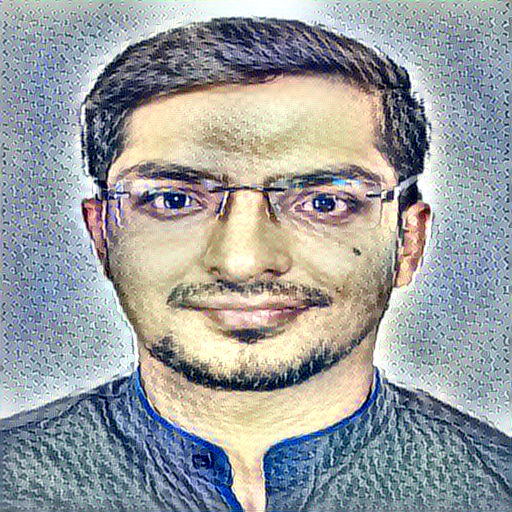

In [62]:
transferred_img = x.reshape((hieght, width, 3))
transferred_img = transferred_img[:, :, ::-1]  #reverse channels from BGR to RGB
#add mean of Imagenet of each channel to get relevant image
transferred_img[:, :, 0] += 103.939  
transferred_img[:, :, 1] += 116.779
transferred_img[:, :, 2] += 123.68
transferred_img = np.clip(transferred_img, 0, 255).astype('uint8')

Image.fromarray(transferred_img)

In [0]:
imsave("morphed_husain.png",transferred_img)

In [0]:
import matplotlib.pyplot as plt

In [0]:
content_array_original[:, :, 0] += 103.939  
content_array_original[:, :, 1] += 116.779
content_array_original[:, :, 2] += 123.68
content_array_original = np.clip(content_array_original, 0, 255).astype('uint8')

In [0]:
style_array_original[:, :, 0] += 103.939  
style_array_original[:, :, 1] += 116.779
style_array_original[:, :, 2] += 123.68
style_array_original = np.clip(style_array_original, 0, 255).astype('uint8')

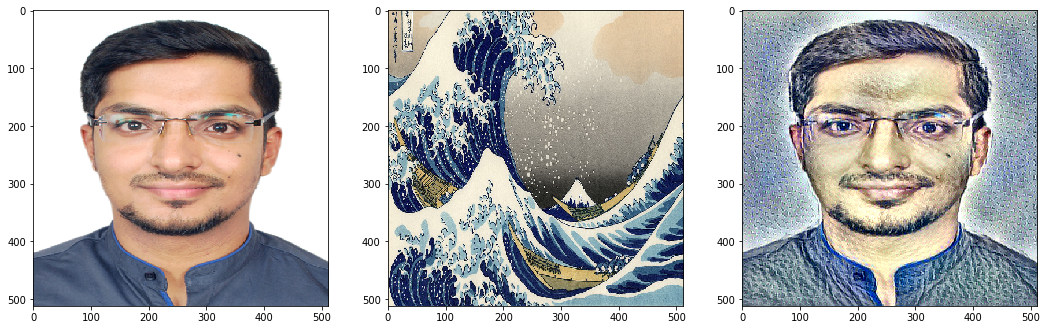

In [76]:
plt.figure(figsize=(18,20))
plt.subplot(1,3,1)
plt.imshow(content_array_original)
plt.subplot(1,3,2)
plt.imshow(style_array_original)
plt.subplot(1,3,3)
plt.imshow(transferred_img)